In [ ]:
# Filter the laws dataset for entries that are likely to be related to CO2 emission reductions
# We look for keywords in the Title or Text columns that might indicate relevance
import pandas as pd

# Load the dataset
laws_df = pd.read_csv('/content/state_laws_and_incentives.csv')


keywords = ['CO2', 'emission', 'carbon', 'greenhouse', 'clean air', 'renewable energy']

# Lowercase the text for case-insensitive matching
laws_df['Title_lower'] = laws_df['Title'].str.lower()
laws_df['Text_lower'] = laws_df['Text'].str.lower()

# Filter rows where any keyword is found in either the Title or Text
filtered_laws_df = laws_df[
    laws_df.apply(lambda x: any(keyword in x['Title_lower'] or keyword in x['Text_lower'] for keyword in keywords), axis=1)
]

# We'll also remove entries that don't have a specific state associated with them to focus on state-level policies
filtered_state_laws_df = filtered_laws_df[filtered_laws_df['State'] != 'US']

filtered_state_laws_df[['Law Id', 'State', 'Title', 'Enacted Date', 'Amended Date']].head()


,Law Id,State,Title,Enacted Date,Amended Date
0,202,CO,Low Emission Vehicle (LEV) Sales Tax Exemption,NaN,2014-06-06 00:00:00 UTC
37,4178,AZ,Zero Emission Vehicle Emissions Test Exemption,2016-01-01 00:00:00 UTC,NaN
39,4216,CA,Air Quality Improvement Program Funding - Vent...,NaN,NaN
40,4219,CA,Employer Invested Emissions Reduction Funding ...,NaN,NaN
43,4249,CA,Zero Emission Vehicle (ZEV) Production Require...,NaN,2022-11-01 00:00:00 UTC


In [ ]:
import numpy as np

emissions_df = pd.read_csv('/content/emissions_per_capita_by_state_renamed.csv')

# Calculate the annual percentage change in emissions for each state
emissions_pct_change = emissions_df.set_index('STATE').pct_change(axis=1)

# Calculate the mean annual percentage change for each state over the entire period
mean_annual_pct_change = emissions_pct_change.mean(axis=1)

# Identify states with the most significant average annual reduction in emissions
# We sort states by their mean annual percentage change in emissions
significant_reduction_states = mean_annual_pct_change.sort_values().head(5).index.tolist()

# Display states with significant reductions and their mean annual percentage change
significant_reduction_states, mean_annual_pct_change.loc[significant_reduction_states]


(['MS', 'OR', 'AR', 'ME', 'NV'],
 STATE
 MS   -0.844800
 OR   -0.120997
 AR   -0.105526
 ME   -0.089642
 NV   -0.021583
 dtype: float64)

In [ ]:
# Calculate the total change in emissions for each state from 1990 to 2021
emissions_df['Total_Change'] = emissions_df['Y2019'] - emissions_df['Y1990']

# Sort the states by their total change in emissions to identify those with the greatest reductions
states_with_greatest_reductions = emissions_df[['STATE', 'Total_Change']].sort_values(by='Total_Change')

# Display the states with the top 5 reductions in emissions
states_with_greatest_reductions.head(5)


,STATE,Total_Change
49,WY,-0.000036
31,NM,-0.000015
43,UT,-0.000013
32,NV,-0.000013
7,DE,-0.000012


In [ ]:
import pandas as pd

# Load your dataset into laws_df
# laws_df = pd.read_csv('path_to_your_file.csv')

# Filter for New York (NY) state policies and create a copy to avoid SettingWithCopyWarning
#try california instead - from NY to CA
ny_policies = laws_df[(laws_df['State'] == 'WA') &
                      (laws_df['Title'].str.lower().str.contains('vehicle'))
                     ].copy()

# Convert Enacted and Amended Dates to datetime and address timezone-awareness
ny_policies['Enacted Date'] = pd.to_datetime(ny_policies['Enacted Date'], errors='coerce').dt.tz_localize(None)
ny_policies['Amended Date'] = pd.to_datetime(ny_policies['Amended Date'], errors='coerce').dt.tz_localize(None)

# Filter policies enacted or amended within 1990-2021
ny_policies_filtered = ny_policies[
    ((ny_policies['Enacted Date'] >= pd.Timestamp('1990-01-01')) & (ny_policies['Enacted Date'] <= pd.Timestamp('2019-12-31'))) |
    ((ny_policies['Amended Date'] >= pd.Timestamp('1990-01-01')) & (ny_policies['Amended Date'] <= pd.Timestamp('2019-12-31')))
]

# Selecting relevant columns to display
ny_policies_relevant = ny_policies_filtered[['Law Id', 'State', 'Title', 'Enacted Date', 'Amended Date', 'Text']]

# Display the filtered DataFrame
print(ny_policies_relevant)


      Law Id State                                              Title  \
72      4805    WA   Natural Gas Vehicle (NGV) and Propane Annual Fee   
125     5567    WA      Alternative Fuel Vehicle Labeling Requirement   
134     5603    WA  Medium-Speed and Neighborhood Electric Vehicle...   
293     6212    WA  State Electric Vehicle (EV) Charging Infrastru...   
296     6216    WA  Zero Emission Vehicle (ZEV) Sales Requirements...   
394     6531    WA  Electric Vehicle (EV) Promotion and Infrastruc...   
395     6532    WA  Electric Vehicle (EV) and Fuel Cell Electric V...   
396     6533    WA  Electric Vehicle (EV) and Battery Exchange Sta...   
397     6534    WA   Electric Vehicle (EV) Infrastructure Definitions   
399     6538    WA  Local Government Electric Vehicle (EV) Infrast...   
441     8220    WA  Low Carbon Fuel and Fuel-Efficient Vehicle Acq...   
549     9974    WA                          Electric Vehicle (EV) Fee   
550     9975    WA  Electric Vehicle (EV) Road User

In [ ]:
import pandas as pd

# Assuming emissions_df is already loaded with the emissions data
# Filter for New York's emissions data
ny_emissions = emissions_df[emissions_df['STATE'] == 'WA']

# Convert the wide format to long format for easier calculations
ny_emissions_long = ny_emissions.melt(id_vars=['STATE'], var_name='Year', value_name='Emissions')
ny_emissions_long['Year'] = ny_emissions_long['Year'].str.extract('(\d+)')[0]  # Extract year as string

# Convert Year to integer and Emissions to float
# Using pd.to_numeric for safe conversion and handling NaNs
ny_emissions_long['Year'] = pd.to_numeric(ny_emissions_long['Year'], errors='coerce')
ny_emissions_long['Emissions'] = pd.to_numeric(ny_emissions_long['Emissions'], errors='coerce')

# Ensure rows with NaN in 'Year' or 'Emissions' are handled (if any)
ny_emissions_long.dropna(subset=['Year', 'Emissions'], inplace=True)

# Convert 'Year' to integer now that NaNs are handled
ny_emissions_long['Year'] = ny_emissions_long['Year'].astype(int)

# Calculate the year-to-year percentage change in emissions
ny_emissions_long.sort_values(by='Year', inplace=True)  # Sort by year
ny_emissions_long['Pct_Change'] = ny_emissions_long['Emissions'].pct_change() * 100


print(ny_emissions_long)

   STATE  Year  Emissions  Pct_Change
0     WA  1990   0.000011         NaN
1     WA  1991   0.000011   -3.425826
2     WA  1992   0.000012   11.087793
3     WA  1993   0.000011   -5.525311
4     WA  1994   0.000012    6.852480
5     WA  1995   0.000011   -5.850484
6     WA  1996   0.000012    4.301147
7     WA  1997   0.000011   -9.730905
8     WA  1998   0.000011    8.281626
9     WA  1999   0.000012    1.953170
10    WA  2000   0.000011   -4.786383
11    WA  2001   0.000010   -9.105145
12    WA  2002   0.000009  -11.150952
13    WA  2003   0.000009    0.527551
14    WA  2004   0.000009    0.292808
15    WA  2005   0.000009    1.240323
16    WA  2006   0.000009   -6.886092
17    WA  2007   0.000009    3.826224
18    WA  2008   0.000008   -4.522094
19    WA  2009   0.000008   -6.770879
20    WA  2010   0.000008   -4.563741
21    WA  2011   0.000006  -15.495808
22    WA  2012   0.000006   -5.107802
23    WA  2013   0.000007   14.250514
24    WA  2014   0.000007   -4.635609
25    WA  20

In [ ]:
# Define the policy enactment years from the previous filtering step
policy_years = [2007, 2005, 2009, 2012, 2013, 2015, 2019]  # Example years based on the policies listed previously

# Identify percentage changes in emissions around the policy years
for year in policy_years:
    pct_change_near_year = ny_emissions_long.loc[ny_emissions_long['Year'].isin([year-1, year, year+1]), :]
    print(f"Percentage Change in Emissions Around {year}:")
    print(pct_change_near_year[['Year', 'Pct_Change']])
    print("\n")


Percentage Change in Emissions Around 2007:
    Year  Pct_Change
16  2006   -6.886092
17  2007    3.826224
18  2008   -4.522094


Percentage Change in Emissions Around 2005:
    Year  Pct_Change
14  2004    0.292808
15  2005    1.240323
16  2006   -6.886092


Percentage Change in Emissions Around 2009:
    Year  Pct_Change
18  2008   -4.522094
19  2009   -6.770879
20  2010   -4.563741


Percentage Change in Emissions Around 2012:
    Year  Pct_Change
21  2011  -15.495808
22  2012   -5.107802
23  2013   14.250514


Percentage Change in Emissions Around 2013:
    Year  Pct_Change
22  2012   -5.107802
23  2013   14.250514
24  2014   -4.635609


Percentage Change in Emissions Around 2015:
    Year  Pct_Change
24  2014   -4.635609
25  2015    0.790528
26  2016   -0.717026


Percentage Change in Emissions Around 2019:
    Year  Pct_Change
28  2018    0.129633
29  2019   10.041996




In [ ]:
#Focus on the Zero Emission Vehicle (ZEV) Sales Requirements policy

In [ ]:
# Assuming laws_df contains the laws and incentives data
# Filter for policies related to ZEV by keywords in the title
zev_related_policies = laws_df[laws_df['Title'].str.contains('Electric Vehicle', case=False, na=False)]

# Get unique states that have ZEV-related policies enacted between 2011 and 2021
zev_policy_states = zev_related_policies[
    ((zev_related_policies['Enacted Date'] >= '2009') & (zev_related_policies['Enacted Date'] <= '2019')) |
    ((zev_related_policies['Amended Date'] >= '2009') & (zev_related_policies['Amended Date'] <= '2019'))
]['State'].unique()

# Assuming 'NY' will be in this list, we remove it since it's our treated unit
zev_policy_states = [state for state in zev_policy_states if state != 'WA']

print("States with similar ZEV-related policies enacted between 2008 and 2021:", zev_policy_states)


States with similar ZEV-related policies enacted between 2008 and 2021: ['US', 'GA', 'TX', 'ID', 'DC', 'OR', 'MN', 'KY', 'HI', 'CO', 'PA', 'CA', 'MD', 'FL', 'ME', 'MI', 'MT', 'NC', 'NV', 'IL', 'VA', 'OH', 'SC', 'NY', 'WY', 'RI', 'UT', 'CT', 'NH', 'MA', 'TN', 'NM', 'WI', 'IN', 'IA', 'MS', 'AL']


In [ ]:
# Assuming emissions_df is your emissions data
all_states = emissions_df['STATE'].unique()

# Excluding states with ZEV-related policies and New York (NY)
control_states = [state for state in all_states if state not in zev_policy_states and state != 'WA']

print("Potential control states:", control_states)


Potential control states: ['AK', 'AR', 'AZ', 'DE', 'KS', 'LA', 'MO', 'ND', 'NE', 'NJ', 'OK', 'SD', 'VT', 'WV']


In [ ]:
# Convert the wide format emissions data to long format for easier manipulation
emissions_long = emissions_df.melt(id_vars=['STATE'], var_name='Year', value_name='Emissions')
emissions_long['Year'] = pd.to_numeric(emissions_long['Year'].str.extract('(\d+)')[0])

# Filter for years up to 2011 (pre-intervention) and for selected states
pre_intervention_data = emissions_long[
    (emissions_long['Year'] <= 2009) &
    (emissions_long['STATE'].isin(['WA'] + control_states))
]

# Ensure emissions are in the correct data type
pre_intervention_data['Emissions'] = pd.to_numeric(pre_intervention_data['Emissions'], errors='coerce')


<ipython-input-9-b673da0e389f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_intervention_data['Emissions'] = pd.to_numeric(pre_intervention_data['Emissions'], errors='coerce')


In [ ]:
# Pivot the DataFrame to have years as columns and states as rows
pre_intervention_pivot = pre_intervention_data.pivot(index='STATE', columns='Year', values='Emissions')

# Display the pivoted DataFrame
print(pre_intervention_pivot.head())


Year         1990.0        1991.0    1992.0        1993.0    1994.0    1995.0  \
STATE                                                                           
AK     4.957328e-05  3.854538e-05  0.000024  2.647673e-05  0.000026  0.000032   
AR    -4.859711e-08 -1.411474e-07  0.000001  8.736751e-07  0.000003  0.000005   
AZ     1.875453e-05  1.805932e-05  0.000018  1.843979e-05  0.000018  0.000016   
DE     2.542184e-05  2.408398e-05  0.000024  2.547131e-05  0.000025  0.000023   
KS     2.551968e-05  2.515157e-05  0.000024  2.632662e-05  0.000026  0.000025   

Year     1996.0    1997.0    1998.0    1999.0    2000.0    2001.0    2002.0  \
STATE                                                                         
AK     0.000037  0.000031  0.000043  0.000047  0.000045  0.000039  0.000085   
AR     0.000006  0.000006  0.000007  0.000008  0.000008  0.000008  0.000007   
AZ     0.000017  0.000017  0.000018  0.000018  0.000017  0.000017  0.000017   
DE     0.000023  0.000021  0.000020  

In [ ]:
from sklearn.linear_model import LinearRegression

# Prepare the data: New York as 'y' and control states as 'X'
X = pre_intervention_pivot.loc[control_states].fillna(0)  # Control states' emissions, filling any NaNs with 0
y = pre_intervention_pivot.loc['WA'].fillna(0)  # New York's emissions, filling any NaNs with 0

# Fit a linear model
model = LinearRegression(fit_intercept=False)  # No intercept to mimic sum(weights) = 1
model.fit(X.T, y)

# The model coefficients can serve as an approximation of the weights
weights = model.coef_
print("Approximate weights for control states:", weights)


Approximate weights for control states: [ 0.00204483  0.24354555  0.26350483  0.18661418 -0.14127248  0.03947836
 -0.22878623  0.18422653  0.0523107   0.84266019 -0.54181424 -0.17273109
 -0.04007701 -0.06020288]


In [ ]:
import numpy as np
import cvxpy as cp

X_np = X.values

# Number of control units (states)
n = X_np.shape[0]

# Define the weights variable with 'n' elements
w = cp.Variable((n, 1))  # Explicitly define 'w' as a column vector

# Convert 'y' from a pandas Series to a 2D numpy array if it's not already
if isinstance(y, pd.Series):
    y_np = y.to_numpy().reshape(-1, 1)
else:
    y_np = y  # Assuming 'y' is already a numpy array with shape (21, 1)

# Now, re-define the objective function with the correct shapes
objective = cp.Minimize(cp.norm(X_np.T @ w - y_np, 'fro'))

# Redefine the constraints and problem as before
constraints = [w >= 0, cp.sum(w) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()

# Extract the optimized weights, ensuring they are flattened for later use
optimized_weights = w.value.flatten()  # Use flatten to create a 1D array

print("Optimized weights for control states:", optimized_weights)


Optimized weights for control states: [7.07443366e-08 2.15062807e-06 4.50348249e-06 3.72459808e-01
 1.27468847e-06 1.72701615e-06 9.58639082e-07 5.65661990e-07
 1.21880931e-06 2.48961338e-01 1.03688778e-06 1.65074868e-06
 3.78563279e-01 4.16710453e-07]


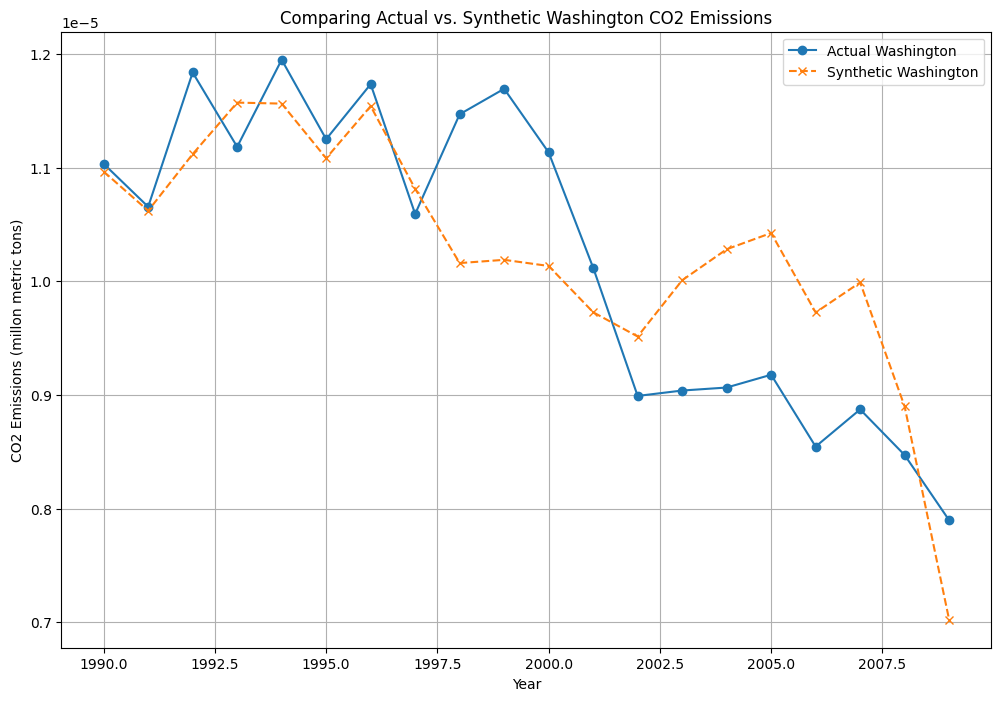

In [ ]:
# Ensure 'optimized_weights' is correctly shaped as (33,) for the dot operation
optimized_weights_reshaped = optimized_weights.flatten()

# Correct the dot product operation
synthetic_ny_emissions = np.dot(X.values.T, optimized_weights_reshaped)

# Convert the pandas Series 'y' to a numpy array and flatten it
actual_ny_emissions = y.to_numpy().flatten()

# Assuming 'years' is a numpy array or a list
years = pre_intervention_pivot.columns.to_numpy()

# The rest of your plotting code seems correct
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(years, actual_ny_emissions, label='Actual Washington', marker='o')
plt.plot(years, synthetic_ny_emissions, label='Synthetic Washington', linestyle='--', marker='x')
plt.title('Comparing Actual vs. Synthetic Washington CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (millon metric tons)')
plt.legend()
plt.grid(True)
plt.show()



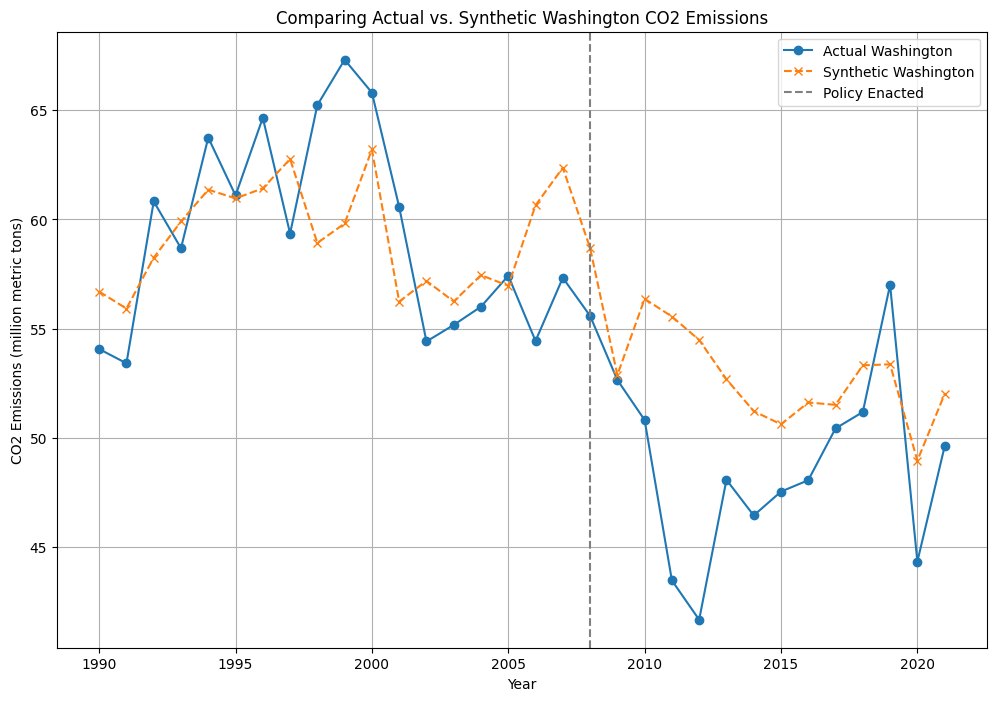

In [ ]:
# Extend the analysis to the post-intervention period.
# Assuming you have the emissions data for the control states and New York for the years after 2011

# Post-intervention emissions data for the control states and New York
post_intervention_data = emissions_long[
    (emissions_long['Year'] > 2009) &
    (emissions_long['STATE'].isin(['WA'] + control_states))
]

# Pivot this data similarly to before
post_intervention_pivot = post_intervention_data.pivot(index='STATE', columns='Year', values='Emissions')

# Get the actual post-intervention emissions for New York
actual_post_ny_emissions = post_intervention_pivot.loc['WA']

# Predict the synthetic post-intervention emissions for New York using the control states and optimized weights
synthetic_post_ny_emissions = np.dot(post_intervention_pivot.loc[control_states].fillna(0).values.T, optimized_weights_reshaped)

# Now we plot both pre-intervention and post-intervention actual vs. synthetic emissions

# Combine pre and post data
all_years = np.concatenate((years, post_intervention_pivot.columns))
all_actual_emissions = np.concatenate((actual_ny_emissions, actual_post_ny_emissions.values))
all_synthetic_emissions = np.concatenate((synthetic_ny_emissions, synthetic_post_ny_emissions))

plt.figure(figsize=(12, 8))
plt.plot(all_years, all_actual_emissions, label='Actual Washington', marker='o')
plt.plot(all_years, all_synthetic_emissions, label='Synthetic Washington', linestyle='--', marker='x')
plt.axvline(x=2008, color='grey', linestyle='--', label='Policy Enacted')  # Line indicating policy enactment
plt.title('Comparing Actual vs. Synthetic Washington CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.legend()
plt.grid(True)
plt.show()
